### How To: Design simple sequences using ChromBPNet
Author: Jacob Schreiber

One of the most important downstream applications of genomics machine learning models is designing sequences with desired characteristics. Although the precise details of these design algorithms differ significantly, the process of training a model and designing sequences is *modular* in the sense that most design algorithms can be paired with most supervised predictive models. Note that there are, separately, a class of purely generative models whose outputs directly are designs and who do not need a separate design algorithm to be applied to them. Here, we will apply several design algorithms to a ChromBPNet model and demonstrate how simple it is to design sequences with particular characteristics.

We will be using the same ChromBPNet model as in the other tutorials, and pairing it with three design algorithms: screening, greedy substitution, and Ledidi. Each pairing is only a few lines of code. Hopefully, the ideas contained here will inspire your own design work. The same process that is outlined here can also be used with BPNet models (or really any predictive model!), with the minor technical note that you will not need to pull out the accessibility model. 

Let's start off by loading the ChromBPNet model. Here, we will do it directly from the h5 file. Please see the tutorial on loading, saving, and converting models, if you have questions about how to load models trained using the official repositories.

In [1]:
import tarfile

from io import BytesIO
from bpnetlite.chrombpnet import ChromBPNet

with tarfile.open("ENCFF142IOR.tar.gz", "r:gz") as tar:
    bias_tar = tar.extractfile("./fold_0/model.bias_scaled.fold_0.ENCSR637XSC.h5").read()
    accessibility_tar = tar.extractfile("./fold_0/model.chrombpnet_nobias.fold_0.ENCSR637XSC.h5").read()

chrombpnet = ChromBPNet.from_chrombpnet(
    BytesIO(bias_tar),
    BytesIO(accessibility_tar)
)

chrombpnet

ChromBPNet(
  (bias): BPNet(
    (iconv): Conv1d(4, 128, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
      (2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
      (3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    )
    (rrelus): ModuleList(
      (0-3): 4 x ReLU()
    )
    (fconv): Conv1d(128, 1, kernel_size=(75,), stride=(1,), padding=(37,))
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
  (accessibility): BPNet(
    (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
    (irelu): ReLU()
    (rconvs): ModuleList(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
      (1): Conv1d(512, 512, kernel_size=(3,), stride=(1

#### Screening

Potentially, the simplest design method is *screening*, where batches of sequences are randomly generated and scored by the model, and the best sequences are kept after a specified number of rounds. This score can be anything, including simply looking for the highest/lowest prediction from the model, or being the distance from a user-defined set of values. An advantage of screening is that it is *super simple* to implement, is amenable to any type of scoring function, including those that are not differentiable, and, when the sequence space is small enough and a model is fast enough, can quickly explore a good chunk of the space. Perhaps counterintuitively, screening can also be useful when you have a massive model and/or sequence length because most other algorithms will take too long to do even a small number of iterations, whereas screening allows you to get mediocre sequences with even a modest compute budget.

Let's see screening in action by pairing it with ChromBPNet to design regions that are very accessible according to the predicted log counts. The default batch size is 32, so let's start off by generating 320 sequences and taking the design whose predictions are closest to 10.0. Note that we do not need to start with an initial sequence because each batch is being randomly generated. For more details on the screening implementation, see the tutorial in the tangermeme documentation.

In [2]:
import torch
from tangermeme.design import screen
from bpnetlite.bpnet import CountWrapper

y_bar = torch.tensor([[10]])

X_bar0 = screen(CountWrapper(chrombpnet), shape=(4, 2114), y=y_bar, max_iter=10, random_state=0)

/home/jmschrei/anaconda3/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Note how simple it was to begin doing design with ChromBPNet. All you needed to do was slice out the count predictions and pass the wrapper into a general-purpose design function. 

We can check how good this design is by checking what the predictions are for it and seeing if they are close at all to 10.0.

In [3]:
from tangermeme.predict import predict

predict(chrombpnet, X_bar0)[1]

tensor([[8.9038]])

That seems okay. Does running screening for longer help?

In [4]:
X_bar1 = screen(CountWrapper(chrombpnet), shape=(4, 2114), y=y_bar, max_iter=100, random_state=0)
predict(chrombpnet, X_bar1)[1]

tensor([[8.9688]])

Seems like running the algorithm for 10x as long helps... but only a bit. 

At this point we should ask: what is driving this accessibility? Can randomly generating a few thousand sequences really come up with anything that has meaningful motifs and syntax in it by chance? We can answer this using feature attribution methods, which highlight the nucleotides driving model predictions. Here, we will focus on interpreting the count predictions, as these were used in the screening process. 

In [5]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = deep_lift_shap(CountWrapper(chrombpnet.accessibility), X_bar1, random_state=0)
X_attr.shape

torch.Size([1, 4, 2114])

Now we can visualize these attributions using a built-in logo plotting method based on `logomaker`.

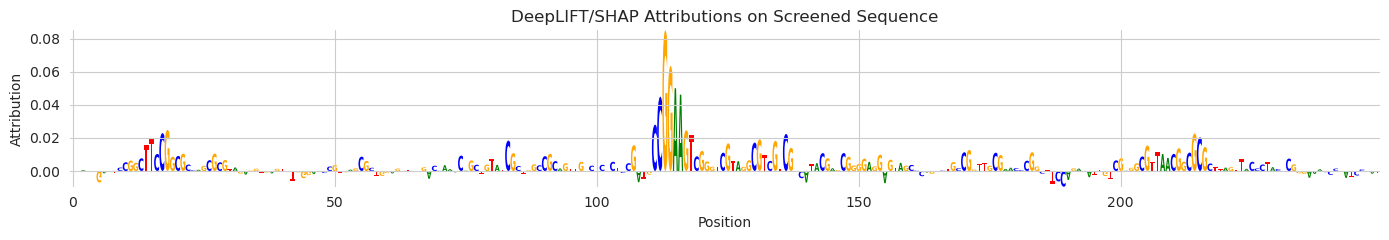

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

from tangermeme.plot import plot_logo

plt.figure(figsize=(14, 2.5))
plt.title("DeepLIFT/SHAP Attributions on Screened Sequence")
plot_logo(X_attr[0], start=750, end=1000)
plt.xlabel("Position")
plt.ylabel("Attribution")
plt.tight_layout()
plt.show()

Looks like an ETS factor (ELF/ELK/ETV) is being highlighted here (the CCGGAAGT motif with high attributions). This makes sense because those factors are known to drive chromatin accessibility in K562 cells. The surrounding regions also seem to have some weaker motifs that the models think are important.

At first, you might think it is unlikely that a strong motif would be present in randomly generated sequences. But, remember that the sequence is 2,114bp long. This means that, by chance, one would expect every 5-mer to happen roughly twice in each sequence. Across a few thousand sequences, how many weak versions of longer motifs do you expect might happen? Binding sites are much more likely to appear in sequences than you initially think.

Returning to screening... does running the procedure for even longer produce better sequences?

In [7]:
X_bar2 = screen(CountWrapper(chrombpnet), shape=(4, 2114), y=y_bar, max_iter=1000, random_state=0)
predict(chrombpnet, X_bar2)[1]

/home/jmschrei/anaconda3/lib/python3.13/site-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[9.3125]])

Looks like that helped a little bit more, but it did take 10x as long as the last run, and 100x as long as the original 10 iterations. This is the key tension with screening: because each batch is generated completely randomly and independently of the previous batches, there is no guarantee that each iteration brings an improved sequence. The only guarantee is a statistical one: in the same way that as you draw more samples from a normal distribution, the expectation of the maximum observed value goes up, so to does the expectation of a stronger example go up as you screen for longer.

#### Greedy Substitution

One of the most widely used iterative design algorithms is *greedy substitution*. In this algorithm, each possible single-nucleotide mutation is considered at each round, and the mutation bringing predictions closest to the desired goal is chosen. This process is repeated until either the predictions are close enough to the target goal or a certain number of iterations were reached. Because we are starting with a sequence (which is usually randomly generated), we need to pass one in to use this design algorithm. Let's start off with a completely uniformly randomly generated sequence but try to achieve the same goal of designing a sequence that causes the model to predict 10.0.

In [8]:
import torch
from tangermeme.design import greedy_substitution

from tangermeme.utils import random_one_hot

X = random_one_hot((1, 4, 2114), random_state=0)
y_bar = torch.tensor([[10.0]])

X_bar0 = greedy_substitution(CountWrapper(chrombpnet), X, y_bar, max_iter=1)

We can then check predictions in the same manner as before.

In [9]:
predict(CountWrapper(chrombpnet), X_bar0)

tensor([[8.1652]])

A single mutation doesn't seem to produce a particularly strong response, which makes sense. Even worse, we had to do 2114*3=6342 forward passes in this single iteration to get this number. Although this is smaller than the 32,000 forward passes used when running 1,000 iterations of screening, it is larger than the 3,200 forward passes used when running 100 iterations (with the default batch size of 32), which gave us a better design. This is what I meant when I said that you can use screening to quickly get okay-ish sequences.

Now, let's run greedy substitution for five iterations and see what happens.

In [10]:
X_bar1 = greedy_substitution(CountWrapper(chrombpnet), X, y_bar, max_iter=5)
predict(CountWrapper(chrombpnet), X_bar1)

tensor([[9.3445]])

Looks like the results are significantly better. Using five mutations, we are able to get designs better than running screening for 1,000 iterations. But just remember that 5*6342 is almost equal to the 32,000 sequences needed to screen 1,000 batches.

But.. it looks like we've basically reached the equivalence point, where both approaches are using roughly the same number of forward passes to get designs of roughly the same quality. Let's use 10 iterations and see what happens.

In [11]:
X_bar2 = greedy_substitution(CountWrapper(chrombpnet), X, y_bar, max_iter=10, verbose=True)
predict(CountWrapper(chrombpnet), X_bar2)

Iteration 0 -- Loss: 5.009, Improvement: N/A, Idx: N/A, Time (s): 0s


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 1 -- Loss: 3.367, Improvement: 1.642, Motif Idx: 1, Pos Idx: 1174, Time (s): 3.247


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 2 -- Loss: 2.199, Improvement: 1.168, Motif Idx: 2, Pos Idx: 1076, Time (s): 3.248


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 3 -- Loss: 1.33, Improvement: 0.869, Motif Idx: 0, Pos Idx: 1148, Time (s): 3.249


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 4 -- Loss: 0.7822, Improvement: 0.5474, Motif Idx: 2, Pos Idx: 1204, Time (s): 3.252


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 5 -- Loss: 0.4295, Improvement: 0.3527, Motif Idx: 2, Pos Idx: 1162, Time (s): 3.252


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 6 -- Loss: 0.2237, Improvement: 0.2058, Motif Idx: 0, Pos Idx: 1103, Time (s): 3.253


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 7 -- Loss: 0.0815, Improvement: 0.1422, Motif Idx: 2, Pos Idx: 1032, Time (s): 3.252


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 8 -- Loss: 0.0158, Improvement: 0.0657, Motif Idx: 2, Pos Idx: 1131, Time (s): 3.251


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]


Iteration 9 -- Loss: 4.508e-07, Improvement: 0.0158, Motif Idx: 2, Pos Idx: 1238, Time (s): 3.255


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.23it/s]

Iteration 10 -- Loss: 1.455e-11, Improvement: 4.507e-07, Motif Idx: 3, Pos Idx: 2066, Time (s): 3.24


tensor([[10.0002]])

At this point we are only using twice as much compute as when we did five iterations but we produce a design that is exactly on the mark. We probably did not even need to do that last iteration, given how small the improvement was. It is unlikely that screening using twice as many batches would have gotten much better than what we saw. It's unlikely that screening using *ten* times as many batches would have gotten much better.

#### Ledidi

Greedy substitution is a nice workhorse for doing design in the sense that it is conceptually simple, not too difficult to implement, and relies only on forward passes so can be made pretty efficient. However, each iteration still involves considering every possible mutation, and only one edit is made in each round, which makes the procedure somewhat slow. Recently, we released a method called Ledidi that uses gradient-based optimization to accelerate the mutation process. As a one-line summary: Ledidi turns the discrete task of choosing edits into a continuous optimization problem that balances trying to reach the desired objective with making the fewest possible edits to do so. Because Ledidi is using gradient-based optimization, it can be much faster than greedy substitution. Let's use the same initial sequence and target objective as before, but just use the `ledidi` function instead of `greedy_substitution`, to see it in action.

In [12]:
from ledidi import ledidi

X_bar = ledidi(CountWrapper(chrombpnet), X.float(), y_bar, verbose=True)

iter=I	input_loss=0.0	output_loss=5.009	total_loss=5.009	time=0.0
iter=100	input_loss=16.81	output_loss=0.1068	total_loss=1.788	time=2.239
iter=F	input_loss=13.81	output_loss=0.08208	total_loss=1.463	time=2.717


Although it looks like Ledidi is performing many more iterations than greedy substitution, remember that each "iteration" of greedy substitution is >6k forward passes, whereas each iteration here is one forward and one backward pass. That means that Ledidi is actually doing over an order of magnitude fewer passes through the model. Accordingly, it looks like Ledidi is around an order of magnitude faster.

But being fast is only half the picture. How good are the designed sequences?

In [13]:
predict(CountWrapper(chrombpnet), X_bar)

tensor([[ 9.8399],
        [ 9.8037],
        [ 9.5224],
        [ 9.8193],
        [ 9.6945],
        [ 9.5917],
        [ 9.5735],
        [ 9.6536],
        [10.1139],
        [ 9.9216],
        [ 9.8524],
        [ 9.5808],
        [ 9.8335],
        [ 9.6704],
        [ 9.7742],
        [ 9.8504]])

Looks like they are pretty good. Not exactly matching 10.0 at machine precision like greedy substitution, but probably within biological noise. The reason these designs do not match exactly is because Ledidi is trying to balance the output loss (distance to 10.0) with minimizing the number of edits made to the initial sequence. The weight between these two objectives is something one can play around with.

Finally, let's do something fun with ChromBPNet. Instead of only focusing on the count head and trying to design something where the counts are high, let's try to create something with a specific pattern: a low intensity peak on the left, and a higher intensity peak on the right hand side. Conceptually, any design algorithm should be able to do this, but Ledidi shines in these kinds of more complex tasks because of how fast it is.

In [14]:
class ProfileWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, X):
        return torch.nn.functional.log_softmax(self.model(X)[0], dim=-1)

y = torch.ones(1000)
y[300:400] += 100.0
y[700:800] += 200.0
y = torch.log(y / y.sum())[None, None]

X_bar = ledidi(ProfileWrapper(chrombpnet), X.float(), y, l=0.01, verbose=True)

iter=I	input_loss=0.0	output_loss=8.81	total_loss=8.81	time=0.0
iter=100	input_loss=274.1	output_loss=2.254	total_loss=4.994	time=1.492
iter=200	input_loss=290.9	output_loss=1.799	total_loss=4.708	time=1.265
iter=300	input_loss=293.0	output_loss=1.656	total_loss=4.586	time=1.28
iter=F	input_loss=288.2	output_loss=1.631	total_loss=4.513	time=5.299


Looks like this kind of design required quite a few edits from the initial sequence. I suppose this is not unexpected given that the desired goal is a bit unusual. But let's see if we were able to achieve it. 

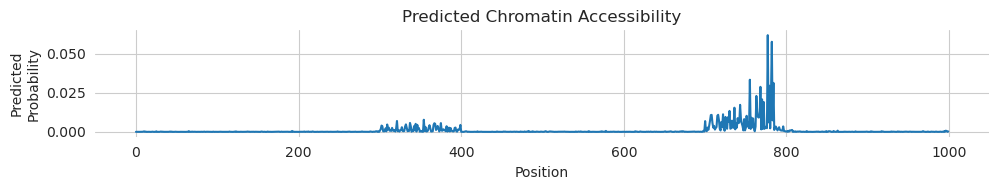

In [15]:
y_bar = predict(ProfileWrapper(chrombpnet), X_bar)
y_bar = torch.exp(y_bar)

plt.figure(figsize=(10, 2))
plt.title("Predicted Chromatin Accessibility")
plt.plot(y_bar[0, 0])
plt.xlabel("Position")
plt.ylabel("Predicted\nProbability")
plt.tight_layout()
seaborn.despine(bottom=True, left=True)
plt.show()

Seems like the predictions are of two peaks, with the left one being a bit weaker than the right one. Note that we used MSE to do this design in log probability space, which is probably not the best way to do such design in practice but is fast to set up for a tutorial like this. Regardless; 